Dataset

In [43]:
import os
import glob
import random
import itertools
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

이미지 크기: (256, 256)


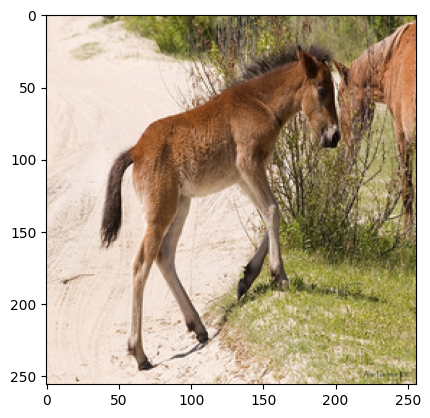

이미지 크기: (256, 256)


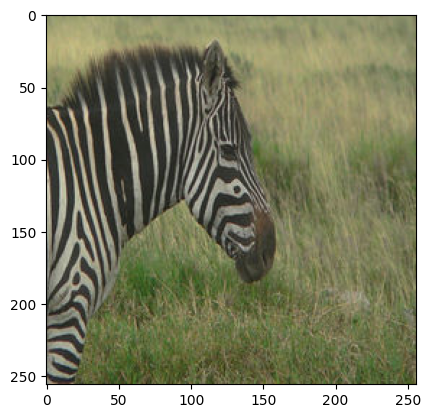

In [44]:
image = Image.open('C:/Users/mmc/cyclegan/horse2zebra/trainA//n02381460_1083.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

# 얼룩말(zebra) 이미지 출력
image = Image.open('C:/Users/mmc/cyclegan/horse2zebra/trainB/n02391049_10007.jpg')
print("이미지 크기:", image.size)

plt.imshow(image)
plt.show()

Custom Dataset

In [ ]:
def to_rgb(image):

    if image.mode == "RGB":
        return image
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class CycleGANDataset(Dataset):
    def __init__(self, root_dir_A, root_dir_B, transform=None): #전체 데이에 관한거 데이터 최상위 root

        self.root_dir_A = root_dir_A
        self.root_dir_B = root_dir_B
        self.transform = transform

        image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')

        self.files_A = [os.path.join(root_dir_A, f) for f in os.listdir(root_dir_A)
                        if os.path.isfile(os.path.join(root_dir_A, f)) and f.lower().endswith(image_extensions)]

        self.files_B = [os.path.join(root_dir_B, f) for f in os.listdir(root_dir_B)
                        if os.path.isfile(os.path.join(root_dir_B, f)) and f.lower().endswith(image_extensions)]

        self.length = max(len(self.files_A), len(self.files_B))


    def __getitem__(self, index): #하나의 데이터 호출마다 실행
   
        path_A = self.files_A[index % len(self.files_A)] 
        img_A = Image.open(path_A)

        path_B = self.files_B[random.randint(0, len(self.files_B) - 1)] # unpair쌍이므로 random 
        img_B = Image.open(path_B)
        
        if img_A.mode != "RGB": # 흑백 -> RGB
            img_A = to_rgb(img_A)
        if img_B.mode != "RGB":
            img_B = to_rgb(img_B)

        if self.transform is not None: 
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return self.length #총 개수

In [46]:
from torchvision import transforms
from PIL import Image 

transform = transforms.Compose([
    transforms.Resize(int(256), interpolation=Image.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


horse1 = "C:/Users/mmc/cyclegan/horse2zebra/trainA/"
horse2 = "C:/Users/mmc/cyclegan/horse2zebra/testA/"

zebra1 = "C:/Users/mmc/cyclegan/horse2zebra/trainB/"
zebra2 = "C:/Users/mmc/cyclegan/horse2zebra/testB/"

train_dataset = CycleGANDataset(horse1,zebra1, transform=transform)
val_dataset = CycleGANDataset(horse2,zebra2, transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

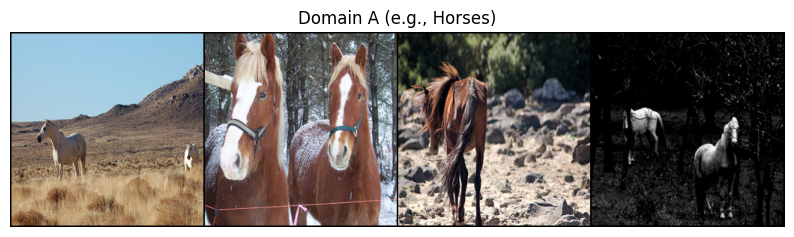

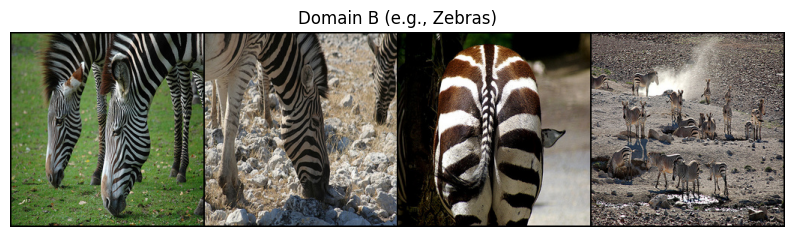

In [47]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def show_images(tensor_batch, title=""):
    """
    tensor_batch: shape [B, C, H, W]
    """
    grid = vutils.make_grid(tensor_batch[:8], nrow=4, normalize=True)  # 최대 8장
    npimg = grid.cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW → HWC
    plt.title(title)
    plt.axis("off")
    plt.show()


data_iter = iter(train_dataloader)
batch = next(data_iter)

images_A = batch["A"]  # domain A 이미지
images_B = batch["B"]  # domain B 이미지

show_images(images_A, title="Domain A (e.g., Horses)")
show_images(images_B, title="Domain B (e.g., Zebras)")

Model

In [48]:

class Residual_Block(nn.Module):
    def __init__(self, channels):
        super(Residual_Block, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),               
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),              
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection



class Generator(nn.Module):
    def __init__(self, nch_in, nch_out):
        super(Generator, self).__init__()

        model = [
        #C7S1-64
        nn.ReflectionPad2d(3),
        nn.Conv2d(3, 64 ,7 , stride=1, padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(),

        #d128
        nn.Conv2d(64, 128 ,3 , stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(),

        #d256
        nn.Conv2d(128, 256 ,3 , stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.ReLU()
        ]

        #R256 x 9
        
        for i in range(9):
            model += [Residual_Block(256)]

        model += [
        #u128
        nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
        nn.InstanceNorm2d(128),
        nn.ReLU(),

        #u64
        nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
        nn.InstanceNorm2d(64),
        nn.ReLU(),

        ##C7S1-3
        # nn.ReflectionPad2d(3),
        nn.Conv2d(64, 3 ,7 , stride=1,padding=1),
        nn.InstanceNorm2d(3),
        nn.Tanh() 
        ]

        self.model = nn.Sequential(*model) #하나로 묶는 역할


    def forward(self,x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, nch_in):
        super(Discriminator, self).__init__()

        model = [

            #C64
            nn.Conv2d(3, 64 , 4 , stride=2),
            nn.LeakyReLU(0.2),
            

            #C128
            nn.Conv2d(64, 128 , 4 , stride=2),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),

            #C256
            nn.Conv2d(128, 256 , 4 , stride=2),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            #C512
            nn.Conv2d(256, 512 , 4 , stride=2),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1)

        ]

        self.model = nn.Sequential(*model) #하나로 묶는 역할


    def forward(self,x):
            return self.model(x)

        

In [37]:
D = Discriminator(nch_in=3) 
print(D)

print("--------------------------------")

G = Generator(nch_in=3, nch_out=3)
print(G)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
--------------------------------
Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (2): InstanceNorm2d(64, eps=1e

In [56]:
class LambdaLR:
    def __init__(self, n_epochs, decay_start_epoch):
        self.n_epochs = n_epochs 
        self.decay_start_epoch = decay_start_epoch 

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)




Train

Epoch [1/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.251, D_Y=0.258, G=2.82]


[Epoch 1/200] D_X: 0.2509 | D_Y: 0.2578 | Generator Loss: 2.8199 | Cycle Loss A: 0.2037, B: 0.2583
[Test] Saved test results for epoch 1


Epoch [2/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.305, D_Y=0.252, G=2.35]


[Epoch 2/200] D_X: 0.3047 | D_Y: 0.2520 | Generator Loss: 2.3461 | Cycle Loss A: 0.2118, B: 0.1932


Epoch [3/200]: 100%|██████████| 334/334 [02:03<00:00,  2.69it/s, D_X=0.24, D_Y=0.281, G=2.28] 


[Epoch 3/200] D_X: 0.2397 | D_Y: 0.2813 | Generator Loss: 2.2759 | Cycle Loss A: 0.1679, B: 0.2004


Epoch [4/200]: 100%|██████████| 334/334 [02:03<00:00,  2.70it/s, D_X=0.217, D_Y=0.228, G=2.94]


[Epoch 4/200] D_X: 0.2165 | D_Y: 0.2283 | Generator Loss: 2.9353 | Cycle Loss A: 0.3098, B: 0.2170


Epoch [5/200]: 100%|██████████| 334/334 [02:03<00:00,  2.72it/s, D_X=0.2, D_Y=0.297, G=2.18]   


[Epoch 5/200] D_X: 0.2004 | D_Y: 0.2975 | Generator Loss: 2.1830 | Cycle Loss A: 0.1633, B: 0.2051


Epoch [6/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.167, D_Y=0.194, G=2.86] 


[Epoch 6/200] D_X: 0.1668 | D_Y: 0.1943 | Generator Loss: 2.8586 | Cycle Loss A: 0.1724, B: 0.2959


Epoch [7/200]: 100%|██████████| 334/334 [01:58<00:00,  2.81it/s, D_X=0.232, D_Y=0.282, G=2.17] 


[Epoch 7/200] D_X: 0.2318 | D_Y: 0.2818 | Generator Loss: 2.1687 | Cycle Loss A: 0.1363, B: 0.2370


Epoch [8/200]: 100%|██████████| 334/334 [01:59<00:00,  2.80it/s, D_X=0.192, D_Y=0.09, G=2.99]  


[Epoch 8/200] D_X: 0.1924 | D_Y: 0.0900 | Generator Loss: 2.9858 | Cycle Loss A: 0.3383, B: 0.1746


Epoch [9/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.257, D_Y=0.204, G=2.12] 


[Epoch 9/200] D_X: 0.2575 | D_Y: 0.2043 | Generator Loss: 2.1151 | Cycle Loss A: 0.2169, B: 0.1359


Epoch [10/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.0996, D_Y=0.425, G=3.06]


[Epoch 10/200] D_X: 0.0996 | D_Y: 0.4248 | Generator Loss: 3.0607 | Cycle Loss A: 0.2417, B: 0.2814


Epoch [11/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.119, D_Y=0.264, G=2.41] 


[Epoch 11/200] D_X: 0.1187 | D_Y: 0.2638 | Generator Loss: 2.4136 | Cycle Loss A: 0.2256, B: 0.1883


Epoch [12/200]: 100%|██████████| 334/334 [01:54<00:00,  2.92it/s, D_X=0.106, D_Y=0.13, G=2.9]   


[Epoch 12/200] D_X: 0.1062 | D_Y: 0.1295 | Generator Loss: 2.8974 | Cycle Loss A: 0.1963, B: 0.2691


Epoch [13/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.125, D_Y=0.0846, G=3.18]


[Epoch 13/200] D_X: 0.1251 | D_Y: 0.0846 | Generator Loss: 3.1837 | Cycle Loss A: 0.2770, B: 0.2246


Epoch [14/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.234, D_Y=0.207, G=2.23] 


[Epoch 14/200] D_X: 0.2342 | D_Y: 0.2069 | Generator Loss: 2.2259 | Cycle Loss A: 0.1982, B: 0.1674


Epoch [15/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.174, D_Y=0.194, G=2]     


[Epoch 15/200] D_X: 0.1737 | D_Y: 0.1942 | Generator Loss: 2.0016 | Cycle Loss A: 0.1600, B: 0.1598


Epoch [16/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.292, D_Y=0.146, G=2.22] 


[Epoch 16/200] D_X: 0.2921 | D_Y: 0.1461 | Generator Loss: 2.2208 | Cycle Loss A: 0.1820, B: 0.1573


Epoch [17/200]: 100%|██████████| 334/334 [01:55<00:00,  2.88it/s, D_X=0.209, D_Y=0.111, G=2]     


[Epoch 17/200] D_X: 0.2089 | D_Y: 0.1106 | Generator Loss: 2.0038 | Cycle Loss A: 0.1643, B: 0.1464


Epoch [18/200]: 100%|██████████| 334/334 [01:56<00:00,  2.86it/s, D_X=0.0747, D_Y=0.197, G=2.12] 


[Epoch 18/200] D_X: 0.0747 | D_Y: 0.1969 | Generator Loss: 2.1150 | Cycle Loss A: 0.1128, B: 0.2067


Epoch [19/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.11, D_Y=0.243, G=2.57]   


[Epoch 19/200] D_X: 0.1103 | D_Y: 0.2430 | Generator Loss: 2.5732 | Cycle Loss A: 0.1968, B: 0.2117


Epoch [20/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.112, D_Y=0.225, G=2.39]  


[Epoch 20/200] D_X: 0.1118 | D_Y: 0.2247 | Generator Loss: 2.3932 | Cycle Loss A: 0.1729, B: 0.1973


Epoch [21/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.166, D_Y=0.344, G=1.9]   


[Epoch 21/200] D_X: 0.1661 | D_Y: 0.3436 | Generator Loss: 1.9047 | Cycle Loss A: 0.1173, B: 0.1543
[Test] Saved test results for epoch 21


Epoch [22/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.111, D_Y=0.312, G=2.4]   


[Epoch 22/200] D_X: 0.1114 | D_Y: 0.3116 | Generator Loss: 2.4023 | Cycle Loss A: 0.1189, B: 0.2567


Epoch [23/200]: 100%|██████████| 334/334 [01:56<00:00,  2.88it/s, D_X=0.396, D_Y=0.0527, G=2.56] 


[Epoch 23/200] D_X: 0.3957 | D_Y: 0.0527 | Generator Loss: 2.5597 | Cycle Loss A: 0.2645, B: 0.1079


Epoch [24/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.124, D_Y=0.168, G=2.13]  


[Epoch 24/200] D_X: 0.1244 | D_Y: 0.1683 | Generator Loss: 2.1296 | Cycle Loss A: 0.1665, B: 0.1509


Epoch [25/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.221, D_Y=0.157, G=2.19]  


[Epoch 25/200] D_X: 0.2206 | D_Y: 0.1571 | Generator Loss: 2.1901 | Cycle Loss A: 0.1355, B: 0.1365


Epoch [26/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.234, D_Y=0.111, G=2.64]  


[Epoch 26/200] D_X: 0.2341 | D_Y: 0.1113 | Generator Loss: 2.6388 | Cycle Loss A: 0.2057, B: 0.1717


Epoch [27/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.162, D_Y=0.0279, G=2.41] 


[Epoch 27/200] D_X: 0.1620 | D_Y: 0.0279 | Generator Loss: 2.4101 | Cycle Loss A: 0.1943, B: 0.1599


Epoch [28/200]: 100%|██████████| 334/334 [01:57<00:00,  2.84it/s, D_X=0.0645, D_Y=0.0704, G=3.51]


[Epoch 28/200] D_X: 0.0645 | D_Y: 0.0704 | Generator Loss: 3.5135 | Cycle Loss A: 0.2921, B: 0.2405


Epoch [29/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0559, D_Y=0.255, G=2.43] 


[Epoch 29/200] D_X: 0.0559 | D_Y: 0.2546 | Generator Loss: 2.4261 | Cycle Loss A: 0.1359, B: 0.2190


Epoch [30/200]: 100%|██████████| 334/334 [01:56<00:00,  2.86it/s, D_X=0.135, D_Y=0.118, G=1.92]  


[Epoch 30/200] D_X: 0.1352 | D_Y: 0.1180 | Generator Loss: 1.9205 | Cycle Loss A: 0.1166, B: 0.1422


Epoch [31/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.0654, D_Y=0.244, G=2.12] 


[Epoch 31/200] D_X: 0.0654 | D_Y: 0.2440 | Generator Loss: 2.1224 | Cycle Loss A: 0.1038, B: 0.1845


Epoch [32/200]: 100%|██████████| 334/334 [01:56<00:00,  2.86it/s, D_X=0.302, D_Y=0.164, G=2.22]  


[Epoch 32/200] D_X: 0.3023 | D_Y: 0.1640 | Generator Loss: 2.2183 | Cycle Loss A: 0.1476, B: 0.1788


Epoch [33/200]: 100%|██████████| 334/334 [01:56<00:00,  2.86it/s, D_X=0.223, D_Y=0.0751, G=2.34] 


[Epoch 33/200] D_X: 0.2227 | D_Y: 0.0751 | Generator Loss: 2.3448 | Cycle Loss A: 0.2089, B: 0.1370


Epoch [34/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.151, D_Y=0.179, G=2.44]  


[Epoch 34/200] D_X: 0.1510 | D_Y: 0.1786 | Generator Loss: 2.4352 | Cycle Loss A: 0.2326, B: 0.1598


Epoch [35/200]: 100%|██████████| 334/334 [01:59<00:00,  2.78it/s, D_X=0.22, D_Y=0.167, G=2.58]   


[Epoch 35/200] D_X: 0.2205 | D_Y: 0.1673 | Generator Loss: 2.5756 | Cycle Loss A: 0.2680, B: 0.1425


Epoch [36/200]: 100%|██████████| 334/334 [01:58<00:00,  2.82it/s, D_X=0.148, D_Y=0.125, G=3.65]  


[Epoch 36/200] D_X: 0.1482 | D_Y: 0.1246 | Generator Loss: 3.6549 | Cycle Loss A: 0.3151, B: 0.3418


Epoch [37/200]: 100%|██████████| 334/334 [01:58<00:00,  2.83it/s, D_X=0.287, D_Y=0.0879, G=2.14] 


[Epoch 37/200] D_X: 0.2865 | D_Y: 0.0879 | Generator Loss: 2.1376 | Cycle Loss A: 0.1557, B: 0.1369


Epoch [38/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.131, D_Y=0.145, G=2.32]  


[Epoch 38/200] D_X: 0.1310 | D_Y: 0.1448 | Generator Loss: 2.3215 | Cycle Loss A: 0.2415, B: 0.1389


Epoch [39/200]: 100%|██████████| 334/334 [01:56<00:00,  2.88it/s, D_X=0.102, D_Y=0.109, G=2.2]   


[Epoch 39/200] D_X: 0.1020 | D_Y: 0.1093 | Generator Loss: 2.2026 | Cycle Loss A: 0.1129, B: 0.1632


Epoch [40/200]: 100%|██████████| 334/334 [01:57<00:00,  2.84it/s, D_X=0.271, D_Y=0.241, G=2.83]  


[Epoch 40/200] D_X: 0.2707 | D_Y: 0.2409 | Generator Loss: 2.8276 | Cycle Loss A: 0.2883, B: 0.1473


Epoch [41/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.118, D_Y=0.0824, G=3.11] 


[Epoch 41/200] D_X: 0.1180 | D_Y: 0.0824 | Generator Loss: 3.1058 | Cycle Loss A: 0.2403, B: 0.2716
[Test] Saved test results for epoch 41


Epoch [42/200]: 100%|██████████| 334/334 [01:56<00:00,  2.87it/s, D_X=0.291, D_Y=0.132, G=2.31]  


[Epoch 42/200] D_X: 0.2912 | D_Y: 0.1322 | Generator Loss: 2.3083 | Cycle Loss A: 0.1095, B: 0.2430


Epoch [43/200]: 100%|██████████| 334/334 [01:55<00:00,  2.88it/s, D_X=0.459, D_Y=0.2, G=2.19]    


[Epoch 43/200] D_X: 0.4587 | D_Y: 0.2003 | Generator Loss: 2.1934 | Cycle Loss A: 0.1230, B: 0.1317


Epoch [44/200]: 100%|██████████| 334/334 [02:02<00:00,  2.72it/s, D_X=0.336, D_Y=0.11, G=1.98]   


[Epoch 44/200] D_X: 0.3363 | D_Y: 0.1095 | Generator Loss: 1.9846 | Cycle Loss A: 0.1045, B: 0.1402


Epoch [45/200]: 100%|██████████| 334/334 [02:02<00:00,  2.72it/s, D_X=0.0714, D_Y=0.166, G=2.27] 


[Epoch 45/200] D_X: 0.0714 | D_Y: 0.1658 | Generator Loss: 2.2715 | Cycle Loss A: 0.1189, B: 0.2056


Epoch [46/200]: 100%|██████████| 334/334 [02:02<00:00,  2.72it/s, D_X=0.061, D_Y=0.159, G=2.24]  


[Epoch 46/200] D_X: 0.0610 | D_Y: 0.1593 | Generator Loss: 2.2390 | Cycle Loss A: 0.1728, B: 0.1304


Epoch [47/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0762, D_Y=0.133, G=2.13] 


[Epoch 47/200] D_X: 0.0762 | D_Y: 0.1329 | Generator Loss: 2.1285 | Cycle Loss A: 0.1157, B: 0.1618


Epoch [48/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.228, D_Y=0.184, G=1.58]  


[Epoch 48/200] D_X: 0.2277 | D_Y: 0.1845 | Generator Loss: 1.5785 | Cycle Loss A: 0.1321, B: 0.0928


Epoch [49/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.269, D_Y=0.146, G=2.11]  


[Epoch 49/200] D_X: 0.2695 | D_Y: 0.1459 | Generator Loss: 2.1125 | Cycle Loss A: 0.1364, B: 0.1018


Epoch [50/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0321, D_Y=0.0664, G=2.42]


[Epoch 50/200] D_X: 0.0321 | D_Y: 0.0664 | Generator Loss: 2.4171 | Cycle Loss A: 0.1367, B: 0.1938


Epoch [51/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0362, D_Y=0.205, G=1.85] 


[Epoch 51/200] D_X: 0.0362 | D_Y: 0.2053 | Generator Loss: 1.8532 | Cycle Loss A: 0.0809, B: 0.1532


Epoch [52/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.217, D_Y=0.0555, G=2.13] 


[Epoch 52/200] D_X: 0.2169 | D_Y: 0.0555 | Generator Loss: 2.1303 | Cycle Loss A: 0.1379, B: 0.1322


Epoch [53/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.236, D_Y=0.0726, G=2.03] 


[Epoch 53/200] D_X: 0.2362 | D_Y: 0.0726 | Generator Loss: 2.0318 | Cycle Loss A: 0.1455, B: 0.0944


Epoch [54/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0467, D_Y=0.0641, G=2.42]


[Epoch 54/200] D_X: 0.0467 | D_Y: 0.0641 | Generator Loss: 2.4246 | Cycle Loss A: 0.1367, B: 0.2299


Epoch [55/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.106, D_Y=0.138, G=2.17]  


[Epoch 55/200] D_X: 0.1056 | D_Y: 0.1384 | Generator Loss: 2.1742 | Cycle Loss A: 0.1056, B: 0.2055


Epoch [56/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.132, D_Y=0.0331, G=2.53] 


[Epoch 56/200] D_X: 0.1322 | D_Y: 0.0331 | Generator Loss: 2.5322 | Cycle Loss A: 0.2073, B: 0.1420


Epoch [57/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0352, D_Y=0.221, G=1.91] 


[Epoch 57/200] D_X: 0.0352 | D_Y: 0.2214 | Generator Loss: 1.9120 | Cycle Loss A: 0.1021, B: 0.1538


Epoch [58/200]: 100%|██████████| 334/334 [01:57<00:00,  2.85it/s, D_X=0.0657, D_Y=0.0925, G=2.56]


[Epoch 58/200] D_X: 0.0657 | D_Y: 0.0925 | Generator Loss: 2.5560 | Cycle Loss A: 0.1484, B: 0.2516


Epoch [59/200]: 100%|██████████| 334/334 [01:54<00:00,  2.93it/s, D_X=0.0851, D_Y=0.0461, G=2.41]


[Epoch 59/200] D_X: 0.0851 | D_Y: 0.0461 | Generator Loss: 2.4076 | Cycle Loss A: 0.1584, B: 0.1703


Epoch [60/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.0618, D_Y=0.0705, G=1.99]


[Epoch 60/200] D_X: 0.0618 | D_Y: 0.0705 | Generator Loss: 1.9939 | Cycle Loss A: 0.1088, B: 0.1366


Epoch [61/200]: 100%|██████████| 334/334 [02:05<00:00,  2.66it/s, D_X=0.102, D_Y=0.0955, G=2.07] 


[Epoch 61/200] D_X: 0.1017 | D_Y: 0.0955 | Generator Loss: 2.0738 | Cycle Loss A: 0.1384, B: 0.1574
[Test] Saved test results for epoch 61


Epoch [62/200]: 100%|██████████| 334/334 [02:05<00:00,  2.67it/s, D_X=0.033, D_Y=0.0301, G=3.07] 


[Epoch 62/200] D_X: 0.0330 | D_Y: 0.0301 | Generator Loss: 3.0694 | Cycle Loss A: 0.1432, B: 0.2817


Epoch [63/200]: 100%|██████████| 334/334 [02:05<00:00,  2.66it/s, D_X=0.0753, D_Y=0.223, G=2.81] 


[Epoch 63/200] D_X: 0.0753 | D_Y: 0.2233 | Generator Loss: 2.8128 | Cycle Loss A: 0.2584, B: 0.1642


Epoch [64/200]: 100%|██████████| 334/334 [02:08<00:00,  2.61it/s, D_X=0.138, D_Y=0.174, G=2.05]  


[Epoch 64/200] D_X: 0.1380 | D_Y: 0.1743 | Generator Loss: 2.0484 | Cycle Loss A: 0.0842, B: 0.1160


Epoch [65/200]: 100%|██████████| 334/334 [02:08<00:00,  2.59it/s, D_X=0.0972, D_Y=0.296, G=2.32] 


[Epoch 65/200] D_X: 0.0972 | D_Y: 0.2959 | Generator Loss: 2.3230 | Cycle Loss A: 0.1440, B: 0.1295


Epoch [66/200]: 100%|██████████| 334/334 [02:07<00:00,  2.61it/s, D_X=0.0994, D_Y=0.0637, G=1.75]


[Epoch 66/200] D_X: 0.0994 | D_Y: 0.0637 | Generator Loss: 1.7466 | Cycle Loss A: 0.0995, B: 0.1295


Epoch [67/200]: 100%|██████████| 334/334 [02:07<00:00,  2.62it/s, D_X=0.111, D_Y=0.145, G=2.01]  


[Epoch 67/200] D_X: 0.1106 | D_Y: 0.1447 | Generator Loss: 2.0106 | Cycle Loss A: 0.1426, B: 0.1572


Epoch [68/200]: 100%|██████████| 334/334 [02:07<00:00,  2.62it/s, D_X=0.229, D_Y=0.269, G=2.54]  


[Epoch 68/200] D_X: 0.2290 | D_Y: 0.2686 | Generator Loss: 2.5372 | Cycle Loss A: 0.0947, B: 0.1980


Epoch [69/200]: 100%|██████████| 334/334 [02:05<00:00,  2.65it/s, D_X=0.155, D_Y=0.146, G=1.94]  


[Epoch 69/200] D_X: 0.1550 | D_Y: 0.1462 | Generator Loss: 1.9370 | Cycle Loss A: 0.0888, B: 0.2278


Epoch [70/200]: 100%|██████████| 334/334 [02:03<00:00,  2.70it/s, D_X=0.0359, D_Y=0.15, G=2.25]  


[Epoch 70/200] D_X: 0.0359 | D_Y: 0.1497 | Generator Loss: 2.2515 | Cycle Loss A: 0.1352, B: 0.1573


Epoch [71/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0739, D_Y=0.0764, G=1.85]


[Epoch 71/200] D_X: 0.0739 | D_Y: 0.0764 | Generator Loss: 1.8491 | Cycle Loss A: 0.1075, B: 0.0920


Epoch [72/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.173, D_Y=0.0569, G=2.39] 


[Epoch 72/200] D_X: 0.1727 | D_Y: 0.0569 | Generator Loss: 2.3923 | Cycle Loss A: 0.1609, B: 0.1651


Epoch [73/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0462, D_Y=0.0985, G=2.28]


[Epoch 73/200] D_X: 0.0462 | D_Y: 0.0985 | Generator Loss: 2.2817 | Cycle Loss A: 0.1594, B: 0.1596


Epoch [74/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0743, D_Y=0.0617, G=2.12]


[Epoch 74/200] D_X: 0.0743 | D_Y: 0.0617 | Generator Loss: 2.1204 | Cycle Loss A: 0.1173, B: 0.1606


Epoch [75/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0495, D_Y=0.0242, G=2.68]


[Epoch 75/200] D_X: 0.0495 | D_Y: 0.0242 | Generator Loss: 2.6792 | Cycle Loss A: 0.2368, B: 0.1225


Epoch [76/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.178, D_Y=0.0482, G=2.24] 


[Epoch 76/200] D_X: 0.1779 | D_Y: 0.0482 | Generator Loss: 2.2417 | Cycle Loss A: 0.1333, B: 0.1495


Epoch [77/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0543, D_Y=0.0681, G=2.18]


[Epoch 77/200] D_X: 0.0543 | D_Y: 0.0681 | Generator Loss: 2.1843 | Cycle Loss A: 0.1691, B: 0.1303


Epoch [78/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.076, D_Y=0.122, G=2.09]  


[Epoch 78/200] D_X: 0.0760 | D_Y: 0.1222 | Generator Loss: 2.0865 | Cycle Loss A: 0.0902, B: 0.1350


Epoch [79/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0502, D_Y=0.101, G=2.17] 


[Epoch 79/200] D_X: 0.0502 | D_Y: 0.1011 | Generator Loss: 2.1720 | Cycle Loss A: 0.1197, B: 0.1701


Epoch [80/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0829, D_Y=0.0587, G=1.86]


[Epoch 80/200] D_X: 0.0829 | D_Y: 0.0587 | Generator Loss: 1.8623 | Cycle Loss A: 0.1121, B: 0.1367


Epoch [81/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.195, D_Y=0.0877, G=2.91] 


[Epoch 81/200] D_X: 0.1946 | D_Y: 0.0877 | Generator Loss: 2.9054 | Cycle Loss A: 0.3903, B: 0.0887
[Test] Saved test results for epoch 81


Epoch [82/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0607, D_Y=0.155, G=1.64] 


[Epoch 82/200] D_X: 0.0607 | D_Y: 0.1548 | Generator Loss: 1.6358 | Cycle Loss A: 0.0955, B: 0.1203


Epoch [83/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0313, D_Y=0.15, G=1.96]  


[Epoch 83/200] D_X: 0.0313 | D_Y: 0.1501 | Generator Loss: 1.9646 | Cycle Loss A: 0.1212, B: 0.1380


Epoch [84/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0593, D_Y=0.0193, G=2.09]


[Epoch 84/200] D_X: 0.0593 | D_Y: 0.0193 | Generator Loss: 2.0853 | Cycle Loss A: 0.1284, B: 0.1115


Epoch [85/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0841, D_Y=0.137, G=1.51] 


[Epoch 85/200] D_X: 0.0841 | D_Y: 0.1367 | Generator Loss: 1.5132 | Cycle Loss A: 0.0916, B: 0.0925


Epoch [86/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0308, D_Y=0.194, G=1.72] 


[Epoch 86/200] D_X: 0.0308 | D_Y: 0.1936 | Generator Loss: 1.7231 | Cycle Loss A: 0.0990, B: 0.1136


Epoch [87/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0621, D_Y=0.167, G=2.71] 


[Epoch 87/200] D_X: 0.0621 | D_Y: 0.1675 | Generator Loss: 2.7083 | Cycle Loss A: 0.1015, B: 0.2703


Epoch [88/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.118, D_Y=0.0276, G=2.39] 


[Epoch 88/200] D_X: 0.1178 | D_Y: 0.0276 | Generator Loss: 2.3873 | Cycle Loss A: 0.1684, B: 0.1335


Epoch [89/200]: 100%|██████████| 334/334 [02:03<00:00,  2.70it/s, D_X=0.094, D_Y=0.0574, G=1.96] 


[Epoch 89/200] D_X: 0.0940 | D_Y: 0.0574 | Generator Loss: 1.9585 | Cycle Loss A: 0.1367, B: 0.1201


Epoch [90/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0446, D_Y=0.1, G=2.56]   


[Epoch 90/200] D_X: 0.0446 | D_Y: 0.1005 | Generator Loss: 2.5562 | Cycle Loss A: 0.2533, B: 0.1392


Epoch [91/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0991, D_Y=0.03, G=2.08]  


[Epoch 91/200] D_X: 0.0991 | D_Y: 0.0300 | Generator Loss: 2.0831 | Cycle Loss A: 0.1161, B: 0.1856


Epoch [92/200]: 100%|██████████| 334/334 [02:02<00:00,  2.72it/s, D_X=0.226, D_Y=0.147, G=2.36]  


[Epoch 92/200] D_X: 0.2259 | D_Y: 0.1474 | Generator Loss: 2.3593 | Cycle Loss A: 0.0994, B: 0.2684


Epoch [93/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0507, D_Y=0.246, G=1.7]  


[Epoch 93/200] D_X: 0.0507 | D_Y: 0.2457 | Generator Loss: 1.7011 | Cycle Loss A: 0.0627, B: 0.1549


Epoch [94/200]: 100%|██████████| 334/334 [02:04<00:00,  2.69it/s, D_X=0.122, D_Y=0.222, G=1.84]  


[Epoch 94/200] D_X: 0.1222 | D_Y: 0.2217 | Generator Loss: 1.8443 | Cycle Loss A: 0.0748, B: 0.1049


Epoch [95/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.112, D_Y=0.125, G=2.07]  


[Epoch 95/200] D_X: 0.1122 | D_Y: 0.1246 | Generator Loss: 2.0654 | Cycle Loss A: 0.1264, B: 0.0957


Epoch [96/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.0759, D_Y=0.043, G=1.98] 


[Epoch 96/200] D_X: 0.0759 | D_Y: 0.0430 | Generator Loss: 1.9830 | Cycle Loss A: 0.1321, B: 0.1389


Epoch [97/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.0368, D_Y=0.153, G=2.14] 


[Epoch 97/200] D_X: 0.0368 | D_Y: 0.1530 | Generator Loss: 2.1395 | Cycle Loss A: 0.1264, B: 0.1009


Epoch [98/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.0453, D_Y=0.153, G=3.03] 


[Epoch 98/200] D_X: 0.0453 | D_Y: 0.1526 | Generator Loss: 3.0346 | Cycle Loss A: 0.1308, B: 0.3630


Epoch [99/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.2, D_Y=0.096, G=1.57]    


[Epoch 99/200] D_X: 0.2004 | D_Y: 0.0960 | Generator Loss: 1.5651 | Cycle Loss A: 0.1231, B: 0.0915


Epoch [100/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.233, D_Y=0.0684, G=1.75] 


[Epoch 100/200] D_X: 0.2333 | D_Y: 0.0684 | Generator Loss: 1.7512 | Cycle Loss A: 0.0644, B: 0.1025


Epoch [101/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.0427, D_Y=0.06, G=1.83]  


[Epoch 101/200] D_X: 0.0427 | D_Y: 0.0600 | Generator Loss: 1.8274 | Cycle Loss A: 0.1207, B: 0.1127
[Test] Saved test results for epoch 101


Epoch [102/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.157, D_Y=0.112, G=2.33]  


[Epoch 102/200] D_X: 0.1572 | D_Y: 0.1117 | Generator Loss: 2.3337 | Cycle Loss A: 0.1748, B: 0.1202


Epoch [103/200]: 100%|██████████| 334/334 [02:04<00:00,  2.68it/s, D_X=0.0598, D_Y=0.0609, G=2.28]


[Epoch 103/200] D_X: 0.0598 | D_Y: 0.0609 | Generator Loss: 2.2839 | Cycle Loss A: 0.1921, B: 0.1246


Epoch [104/200]: 100%|██████████| 334/334 [02:06<00:00,  2.64it/s, D_X=0.0762, D_Y=0.162, G=1.84] 


[Epoch 104/200] D_X: 0.0762 | D_Y: 0.1622 | Generator Loss: 1.8362 | Cycle Loss A: 0.0932, B: 0.1137


Epoch [105/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.0277, D_Y=0.0786, G=1.94]


[Epoch 105/200] D_X: 0.0277 | D_Y: 0.0786 | Generator Loss: 1.9375 | Cycle Loss A: 0.0689, B: 0.1246


Epoch [106/200]: 100%|██████████| 334/334 [02:07<00:00,  2.62it/s, D_X=0.0424, D_Y=0.0312, G=2.09]


[Epoch 106/200] D_X: 0.0424 | D_Y: 0.0312 | Generator Loss: 2.0891 | Cycle Loss A: 0.1124, B: 0.1461


Epoch [107/200]: 100%|██████████| 334/334 [02:01<00:00,  2.76it/s, D_X=0.14, D_Y=0.0345, G=1.8]   


[Epoch 107/200] D_X: 0.1398 | D_Y: 0.0345 | Generator Loss: 1.7975 | Cycle Loss A: 0.1071, B: 0.0942


Epoch [108/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.0308, D_Y=0.231, G=1.93] 


[Epoch 108/200] D_X: 0.0308 | D_Y: 0.2314 | Generator Loss: 1.9299 | Cycle Loss A: 0.0854, B: 0.1188


Epoch [109/200]: 100%|██████████| 334/334 [01:56<00:00,  2.86it/s, D_X=0.0622, D_Y=0.0707, G=2.75]


[Epoch 109/200] D_X: 0.0622 | D_Y: 0.0707 | Generator Loss: 2.7466 | Cycle Loss A: 0.2383, B: 0.1479


Epoch [110/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.0388, D_Y=0.121, G=1.88] 


[Epoch 110/200] D_X: 0.0388 | D_Y: 0.1205 | Generator Loss: 1.8763 | Cycle Loss A: 0.0873, B: 0.1162


Epoch [111/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.043, D_Y=0.102, G=2.18]  


[Epoch 111/200] D_X: 0.0430 | D_Y: 0.1022 | Generator Loss: 2.1846 | Cycle Loss A: 0.1095, B: 0.1960


Epoch [112/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.21, D_Y=0.041, G=1.94]   


[Epoch 112/200] D_X: 0.2104 | D_Y: 0.0410 | Generator Loss: 1.9386 | Cycle Loss A: 0.1110, B: 0.0858


Epoch [113/200]: 100%|██████████| 334/334 [01:54<00:00,  2.91it/s, D_X=0.0225, D_Y=0.039, G=2.19] 


[Epoch 113/200] D_X: 0.0225 | D_Y: 0.0390 | Generator Loss: 2.1940 | Cycle Loss A: 0.1146, B: 0.1761


Epoch [114/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.148, D_Y=0.0354, G=2.45] 


[Epoch 114/200] D_X: 0.1475 | D_Y: 0.0354 | Generator Loss: 2.4517 | Cycle Loss A: 0.2137, B: 0.1407


Epoch [115/200]: 100%|██████████| 334/334 [02:03<00:00,  2.71it/s, D_X=0.146, D_Y=0.186, G=1.67]  


[Epoch 115/200] D_X: 0.1456 | D_Y: 0.1864 | Generator Loss: 1.6713 | Cycle Loss A: 0.0790, B: 0.1003


Epoch [116/200]: 100%|██████████| 334/334 [02:01<00:00,  2.74it/s, D_X=0.138, D_Y=0.0307, G=2.46] 


[Epoch 116/200] D_X: 0.1376 | D_Y: 0.0307 | Generator Loss: 2.4597 | Cycle Loss A: 0.2542, B: 0.1197


Epoch [117/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.0683, D_Y=0.0471, G=2.2] 


[Epoch 117/200] D_X: 0.0683 | D_Y: 0.0471 | Generator Loss: 2.2040 | Cycle Loss A: 0.1713, B: 0.1429


Epoch [118/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.483, D_Y=0.136, G=1.61]  


[Epoch 118/200] D_X: 0.4827 | D_Y: 0.1362 | Generator Loss: 1.6144 | Cycle Loss A: 0.0936, B: 0.0656


Epoch [119/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.0491, D_Y=0.0806, G=2.38]


[Epoch 119/200] D_X: 0.0491 | D_Y: 0.0806 | Generator Loss: 2.3762 | Cycle Loss A: 0.1010, B: 0.2608


Epoch [120/200]: 100%|██████████| 334/334 [01:52<00:00,  2.97it/s, D_X=0.072, D_Y=0.0326, G=2.63] 


[Epoch 120/200] D_X: 0.0720 | D_Y: 0.0326 | Generator Loss: 2.6276 | Cycle Loss A: 0.1935, B: 0.1619


Epoch [121/200]: 100%|██████████| 334/334 [01:52<00:00,  2.97it/s, D_X=0.166, D_Y=0.025, G=1.74]  


[Epoch 121/200] D_X: 0.1660 | D_Y: 0.0250 | Generator Loss: 1.7389 | Cycle Loss A: 0.1103, B: 0.0781
[Test] Saved test results for epoch 121


Epoch [122/200]: 100%|██████████| 334/334 [01:54<00:00,  2.92it/s, D_X=0.153, D_Y=0.101, G=1.78]  


[Epoch 122/200] D_X: 0.1531 | D_Y: 0.1013 | Generator Loss: 1.7829 | Cycle Loss A: 0.1217, B: 0.0904


Epoch [123/200]: 100%|██████████| 334/334 [01:55<00:00,  2.89it/s, D_X=0.13, D_Y=0.0661, G=2.31]  


[Epoch 123/200] D_X: 0.1301 | D_Y: 0.0661 | Generator Loss: 2.3105 | Cycle Loss A: 0.1175, B: 0.1581


Epoch [124/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.142, D_Y=0.0282, G=2.56] 


[Epoch 124/200] D_X: 0.1419 | D_Y: 0.0282 | Generator Loss: 2.5563 | Cycle Loss A: 0.1318, B: 0.2241


Epoch [125/200]: 100%|██████████| 334/334 [01:53<00:00,  2.94it/s, D_X=0.1, D_Y=0.0752, G=1.56]   


[Epoch 125/200] D_X: 0.1003 | D_Y: 0.0752 | Generator Loss: 1.5611 | Cycle Loss A: 0.1026, B: 0.1009


Epoch [126/200]: 100%|██████████| 334/334 [01:52<00:00,  2.96it/s, D_X=0.0364, D_Y=0.266, G=1.97] 


[Epoch 126/200] D_X: 0.0364 | D_Y: 0.2655 | Generator Loss: 1.9701 | Cycle Loss A: 0.0672, B: 0.1914


Epoch [127/200]: 100%|██████████| 334/334 [01:54<00:00,  2.93it/s, D_X=0.0426, D_Y=0.21, G=1.81]  


[Epoch 127/200] D_X: 0.0426 | D_Y: 0.2099 | Generator Loss: 1.8083 | Cycle Loss A: 0.0581, B: 0.1735


Epoch [128/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.149, D_Y=0.115, G=1.66]  


[Epoch 128/200] D_X: 0.1485 | D_Y: 0.1153 | Generator Loss: 1.6558 | Cycle Loss A: 0.1178, B: 0.0824


Epoch [129/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.0613, D_Y=0.0379, G=1.97]


[Epoch 129/200] D_X: 0.0613 | D_Y: 0.0379 | Generator Loss: 1.9726 | Cycle Loss A: 0.1037, B: 0.1484


Epoch [130/200]: 100%|██████████| 334/334 [01:53<00:00,  2.94it/s, D_X=0.0537, D_Y=0.0752, G=2.22]


[Epoch 130/200] D_X: 0.0537 | D_Y: 0.0752 | Generator Loss: 2.2156 | Cycle Loss A: 0.1373, B: 0.1623


Epoch [131/200]: 100%|██████████| 334/334 [01:52<00:00,  2.97it/s, D_X=0.0239, D_Y=0.153, G=2.17] 


[Epoch 131/200] D_X: 0.0239 | D_Y: 0.1528 | Generator Loss: 2.1745 | Cycle Loss A: 0.1074, B: 0.1549


Epoch [132/200]: 100%|██████████| 334/334 [01:52<00:00,  2.96it/s, D_X=0.115, D_Y=0.0672, G=1.47] 


[Epoch 132/200] D_X: 0.1147 | D_Y: 0.0672 | Generator Loss: 1.4709 | Cycle Loss A: 0.1144, B: 0.0729


Epoch [133/200]: 100%|██████████| 334/334 [01:52<00:00,  2.96it/s, D_X=0.153, D_Y=0.0537, G=2.07] 


[Epoch 133/200] D_X: 0.1535 | D_Y: 0.0537 | Generator Loss: 2.0734 | Cycle Loss A: 0.1665, B: 0.0853


Epoch [134/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.126, D_Y=0.135, G=1.48]  


[Epoch 134/200] D_X: 0.1260 | D_Y: 0.1355 | Generator Loss: 1.4842 | Cycle Loss A: 0.0657, B: 0.1175


Epoch [135/200]: 100%|██████████| 334/334 [01:52<00:00,  2.96it/s, D_X=0.0297, D_Y=0.121, G=2.89] 


[Epoch 135/200] D_X: 0.0297 | D_Y: 0.1214 | Generator Loss: 2.8860 | Cycle Loss A: 0.1879, B: 0.2668


Epoch [136/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.0305, D_Y=0.0406, G=2.84]


[Epoch 136/200] D_X: 0.0305 | D_Y: 0.0406 | Generator Loss: 2.8384 | Cycle Loss A: 0.2033, B: 0.1857


Epoch [137/200]: 100%|██████████| 334/334 [01:53<00:00,  2.94it/s, D_X=0.039, D_Y=0.187, G=1.85]  


[Epoch 137/200] D_X: 0.0390 | D_Y: 0.1872 | Generator Loss: 1.8487 | Cycle Loss A: 0.0842, B: 0.1198


Epoch [138/200]: 100%|██████████| 334/334 [01:53<00:00,  2.93it/s, D_X=0.0497, D_Y=0.0604, G=1.7] 


[Epoch 138/200] D_X: 0.0497 | D_Y: 0.0604 | Generator Loss: 1.7013 | Cycle Loss A: 0.0951, B: 0.1171


Epoch [139/200]: 100%|██████████| 334/334 [01:54<00:00,  2.92it/s, D_X=0.0911, D_Y=0.0417, G=1.57]


[Epoch 139/200] D_X: 0.0911 | D_Y: 0.0417 | Generator Loss: 1.5729 | Cycle Loss A: 0.1013, B: 0.0811


Epoch [140/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.0933, D_Y=0.183, G=2.29] 


[Epoch 140/200] D_X: 0.0933 | D_Y: 0.1832 | Generator Loss: 2.2947 | Cycle Loss A: 0.1807, B: 0.1145


Epoch [141/200]: 100%|██████████| 334/334 [01:53<00:00,  2.96it/s, D_X=0.221, D_Y=0.128, G=2.05]  


[Epoch 141/200] D_X: 0.2214 | D_Y: 0.1281 | Generator Loss: 2.0529 | Cycle Loss A: 0.1151, B: 0.1043
[Test] Saved test results for epoch 141


Epoch [142/200]: 100%|██████████| 334/334 [01:55<00:00,  2.90it/s, D_X=0.0361, D_Y=0.13, G=1.95]  


[Epoch 142/200] D_X: 0.0361 | D_Y: 0.1297 | Generator Loss: 1.9494 | Cycle Loss A: 0.1124, B: 0.1194


Epoch [143/200]: 100%|██████████| 334/334 [01:57<00:00,  2.83it/s, D_X=0.0447, D_Y=0.0649, G=1.83]


[Epoch 143/200] D_X: 0.0447 | D_Y: 0.0649 | Generator Loss: 1.8255 | Cycle Loss A: 0.0789, B: 0.1405


Epoch [144/200]: 100%|██████████| 334/334 [01:52<00:00,  2.96it/s, D_X=0.1, D_Y=0.0237, G=2.64]   


[Epoch 144/200] D_X: 0.1000 | D_Y: 0.0237 | Generator Loss: 2.6436 | Cycle Loss A: 0.2034, B: 0.1735


Epoch [145/200]: 100%|██████████| 334/334 [01:53<00:00,  2.93it/s, D_X=0.0292, D_Y=0.0661, G=2.3] 


[Epoch 145/200] D_X: 0.0292 | D_Y: 0.0661 | Generator Loss: 2.2999 | Cycle Loss A: 0.1609, B: 0.1532


Epoch [146/200]: 100%|██████████| 334/334 [01:53<00:00,  2.95it/s, D_X=0.135, D_Y=0.0724, G=1.65] 


[Epoch 146/200] D_X: 0.1348 | D_Y: 0.0724 | Generator Loss: 1.6464 | Cycle Loss A: 0.0928, B: 0.0964


Epoch [147/200]: 100%|██████████| 334/334 [01:53<00:00,  2.96it/s, D_X=0.032, D_Y=0.0956, G=2.09] 


[Epoch 147/200] D_X: 0.0320 | D_Y: 0.0956 | Generator Loss: 2.0865 | Cycle Loss A: 0.1325, B: 0.1562


Epoch [148/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0563, D_Y=0.0227, G=2.22]


[Epoch 148/200] D_X: 0.0563 | D_Y: 0.0227 | Generator Loss: 2.2185 | Cycle Loss A: 0.0923, B: 0.1969


Epoch [149/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.135, D_Y=0.135, G=1.72]  


[Epoch 149/200] D_X: 0.1352 | D_Y: 0.1350 | Generator Loss: 1.7163 | Cycle Loss A: 0.0820, B: 0.1884


Epoch [150/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0821, D_Y=0.0294, G=1.95]


[Epoch 150/200] D_X: 0.0821 | D_Y: 0.0294 | Generator Loss: 1.9458 | Cycle Loss A: 0.1311, B: 0.1155


Epoch [151/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0426, D_Y=0.203, G=1.86] 


[Epoch 151/200] D_X: 0.0426 | D_Y: 0.2034 | Generator Loss: 1.8602 | Cycle Loss A: 0.0833, B: 0.1619


Epoch [152/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.187, D_Y=0.101, G=1.98]  


[Epoch 152/200] D_X: 0.1871 | D_Y: 0.1005 | Generator Loss: 1.9784 | Cycle Loss A: 0.1588, B: 0.1253


Epoch [153/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0207, D_Y=0.0445, G=2.25]


[Epoch 153/200] D_X: 0.0207 | D_Y: 0.0445 | Generator Loss: 2.2531 | Cycle Loss A: 0.1950, B: 0.1012


Epoch [154/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0448, D_Y=0.109, G=2.16] 


[Epoch 154/200] D_X: 0.0448 | D_Y: 0.1090 | Generator Loss: 2.1554 | Cycle Loss A: 0.1490, B: 0.1400


Epoch [155/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0408, D_Y=0.0444, G=2.53]


[Epoch 155/200] D_X: 0.0408 | D_Y: 0.0444 | Generator Loss: 2.5347 | Cycle Loss A: 0.2568, B: 0.1012


Epoch [156/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.0382, D_Y=0.0625, G=1.8] 


[Epoch 156/200] D_X: 0.0382 | D_Y: 0.0625 | Generator Loss: 1.8031 | Cycle Loss A: 0.1075, B: 0.1166


Epoch [157/200]: 100%|██████████| 334/334 [02:00<00:00,  2.77it/s, D_X=0.0588, D_Y=0.033, G=2.4]  


[Epoch 157/200] D_X: 0.0588 | D_Y: 0.0330 | Generator Loss: 2.3990 | Cycle Loss A: 0.1724, B: 0.1460


Epoch [158/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.0237, D_Y=0.106, G=2.4]  


[Epoch 158/200] D_X: 0.0237 | D_Y: 0.1060 | Generator Loss: 2.3952 | Cycle Loss A: 0.0878, B: 0.1995


Epoch [159/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.163, D_Y=0.0238, G=1.89] 


[Epoch 159/200] D_X: 0.1631 | D_Y: 0.0238 | Generator Loss: 1.8906 | Cycle Loss A: 0.1190, B: 0.0868


Epoch [160/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.0592, D_Y=0.0368, G=1.72]


[Epoch 160/200] D_X: 0.0592 | D_Y: 0.0368 | Generator Loss: 1.7240 | Cycle Loss A: 0.0987, B: 0.0928


Epoch [161/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.0177, D_Y=0.142, G=2.18] 


[Epoch 161/200] D_X: 0.0177 | D_Y: 0.1417 | Generator Loss: 2.1750 | Cycle Loss A: 0.0683, B: 0.1728
[Test] Saved test results for epoch 161


Epoch [162/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.179, D_Y=0.0253, G=1.76] 


[Epoch 162/200] D_X: 0.1791 | D_Y: 0.0253 | Generator Loss: 1.7601 | Cycle Loss A: 0.1302, B: 0.0879


Epoch [163/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.115, D_Y=0.0416, G=1.65] 


[Epoch 163/200] D_X: 0.1148 | D_Y: 0.0416 | Generator Loss: 1.6538 | Cycle Loss A: 0.0889, B: 0.0750


Epoch [164/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.055, D_Y=0.069, G=2.19]  


[Epoch 164/200] D_X: 0.0550 | D_Y: 0.0690 | Generator Loss: 2.1886 | Cycle Loss A: 0.0828, B: 0.2231


Epoch [165/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0839, D_Y=0.0963, G=1.88]


[Epoch 165/200] D_X: 0.0839 | D_Y: 0.0963 | Generator Loss: 1.8825 | Cycle Loss A: 0.1279, B: 0.1285


Epoch [166/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.149, D_Y=0.0769, G=1.54] 


[Epoch 166/200] D_X: 0.1494 | D_Y: 0.0769 | Generator Loss: 1.5394 | Cycle Loss A: 0.0569, B: 0.0812


Epoch [167/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0138, D_Y=0.0432, G=2.5] 


[Epoch 167/200] D_X: 0.0138 | D_Y: 0.0432 | Generator Loss: 2.4966 | Cycle Loss A: 0.1629, B: 0.1688


Epoch [168/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0247, D_Y=0.18, G=2.06]  


[Epoch 168/200] D_X: 0.0247 | D_Y: 0.1803 | Generator Loss: 2.0637 | Cycle Loss A: 0.0902, B: 0.1561


Epoch [169/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0646, D_Y=0.0264, G=1.96]


[Epoch 169/200] D_X: 0.0646 | D_Y: 0.0264 | Generator Loss: 1.9592 | Cycle Loss A: 0.1414, B: 0.0901


Epoch [170/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0598, D_Y=0.042, G=1.52] 


[Epoch 170/200] D_X: 0.0598 | D_Y: 0.0420 | Generator Loss: 1.5197 | Cycle Loss A: 0.0938, B: 0.0846


Epoch [171/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.207, D_Y=0.0819, G=1.42] 


[Epoch 171/200] D_X: 0.2071 | D_Y: 0.0819 | Generator Loss: 1.4234 | Cycle Loss A: 0.0577, B: 0.0778


Epoch [172/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0237, D_Y=0.0184, G=1.66]


[Epoch 172/200] D_X: 0.0237 | D_Y: 0.0184 | Generator Loss: 1.6643 | Cycle Loss A: 0.0737, B: 0.0908


Epoch [173/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0281, D_Y=0.111, G=1.52] 


[Epoch 173/200] D_X: 0.0281 | D_Y: 0.1114 | Generator Loss: 1.5244 | Cycle Loss A: 0.0577, B: 0.0828


Epoch [174/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0429, D_Y=0.0316, G=2.7] 


[Epoch 174/200] D_X: 0.0429 | D_Y: 0.0316 | Generator Loss: 2.6976 | Cycle Loss A: 0.1146, B: 0.2847


Epoch [175/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.131, D_Y=0.0282, G=3.15] 


[Epoch 175/200] D_X: 0.1309 | D_Y: 0.0282 | Generator Loss: 3.1493 | Cycle Loss A: 0.4053, B: 0.0857


Epoch [176/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.0436, D_Y=0.0266, G=2.72]


[Epoch 176/200] D_X: 0.0436 | D_Y: 0.0266 | Generator Loss: 2.7188 | Cycle Loss A: 0.2709, B: 0.1133


Epoch [177/200]: 100%|██████████| 334/334 [01:59<00:00,  2.79it/s, D_X=0.161, D_Y=0.198, G=2.15]  


[Epoch 177/200] D_X: 0.1615 | D_Y: 0.1981 | Generator Loss: 2.1493 | Cycle Loss A: 0.0791, B: 0.1743


Epoch [178/200]: 100%|██████████| 334/334 [01:59<00:00,  2.78it/s, D_X=0.134, D_Y=0.099, G=2]     


[Epoch 178/200] D_X: 0.1343 | D_Y: 0.0990 | Generator Loss: 2.0042 | Cycle Loss A: 0.1190, B: 0.0890


Epoch [179/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.044, D_Y=0.0742, G=1.74] 


[Epoch 179/200] D_X: 0.0440 | D_Y: 0.0742 | Generator Loss: 1.7387 | Cycle Loss A: 0.0691, B: 0.1291


Epoch [180/200]: 100%|██████████| 334/334 [02:00<00:00,  2.78it/s, D_X=0.0602, D_Y=0.0672, G=1.44]


[Epoch 180/200] D_X: 0.0602 | D_Y: 0.0672 | Generator Loss: 1.4378 | Cycle Loss A: 0.0673, B: 0.0829


Epoch [181/200]: 100%|██████████| 334/334 [02:01<00:00,  2.76it/s, D_X=0.0299, D_Y=0.0275, G=2.45]


[Epoch 181/200] D_X: 0.0299 | D_Y: 0.0275 | Generator Loss: 2.4485 | Cycle Loss A: 0.1059, B: 0.2279
[Test] Saved test results for epoch 181


Epoch [182/200]: 100%|██████████| 334/334 [02:02<00:00,  2.74it/s, D_X=0.0482, D_Y=0.0304, G=2.01]


[Epoch 182/200] D_X: 0.0482 | D_Y: 0.0304 | Generator Loss: 2.0093 | Cycle Loss A: 0.1123, B: 0.1431


Epoch [183/200]: 100%|██████████| 334/334 [02:02<00:00,  2.74it/s, D_X=0.0783, D_Y=0.114, G=1.94] 


[Epoch 183/200] D_X: 0.0783 | D_Y: 0.1141 | Generator Loss: 1.9384 | Cycle Loss A: 0.0787, B: 0.1558


Epoch [184/200]: 100%|██████████| 334/334 [02:02<00:00,  2.74it/s, D_X=0.0488, D_Y=0.0216, G=2.3] 


[Epoch 184/200] D_X: 0.0488 | D_Y: 0.0216 | Generator Loss: 2.2975 | Cycle Loss A: 0.1391, B: 0.1655


Epoch [185/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0424, D_Y=0.0867, G=1.93]


[Epoch 185/200] D_X: 0.0424 | D_Y: 0.0867 | Generator Loss: 1.9251 | Cycle Loss A: 0.0852, B: 0.1877


Epoch [186/200]: 100%|██████████| 334/334 [02:02<00:00,  2.74it/s, D_X=0.0316, D_Y=0.113, G=1.96] 


[Epoch 186/200] D_X: 0.0316 | D_Y: 0.1134 | Generator Loss: 1.9615 | Cycle Loss A: 0.0736, B: 0.1696


Epoch [187/200]: 100%|██████████| 334/334 [02:01<00:00,  2.74it/s, D_X=0.0246, D_Y=0.0225, G=2.36]


[Epoch 187/200] D_X: 0.0246 | D_Y: 0.0225 | Generator Loss: 2.3623 | Cycle Loss A: 0.1116, B: 0.2000


Epoch [188/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.122, D_Y=0.0342, G=1.88] 


[Epoch 188/200] D_X: 0.1215 | D_Y: 0.0342 | Generator Loss: 1.8780 | Cycle Loss A: 0.1250, B: 0.0943


Epoch [189/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.151, D_Y=0.0421, G=1.51] 


[Epoch 189/200] D_X: 0.1509 | D_Y: 0.0421 | Generator Loss: 1.5140 | Cycle Loss A: 0.0779, B: 0.0861


Epoch [190/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.243, D_Y=0.0275, G=1.39] 


[Epoch 190/200] D_X: 0.2434 | D_Y: 0.0275 | Generator Loss: 1.3856 | Cycle Loss A: 0.0806, B: 0.0492


Epoch [191/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0388, D_Y=0.0361, G=1.95]


[Epoch 191/200] D_X: 0.0388 | D_Y: 0.0361 | Generator Loss: 1.9514 | Cycle Loss A: 0.0879, B: 0.1419


Epoch [192/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0198, D_Y=0.0185, G=1.82]


[Epoch 192/200] D_X: 0.0198 | D_Y: 0.0185 | Generator Loss: 1.8200 | Cycle Loss A: 0.1137, B: 0.0922


Epoch [193/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0224, D_Y=0.0285, G=2.4] 


[Epoch 193/200] D_X: 0.0224 | D_Y: 0.0285 | Generator Loss: 2.4006 | Cycle Loss A: 0.1873, B: 0.1423


Epoch [194/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0368, D_Y=0.127, G=1.75] 


[Epoch 194/200] D_X: 0.0368 | D_Y: 0.1268 | Generator Loss: 1.7503 | Cycle Loss A: 0.0806, B: 0.1190


Epoch [195/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.03, D_Y=0.141, G=2.25]   


[Epoch 195/200] D_X: 0.0300 | D_Y: 0.1415 | Generator Loss: 2.2514 | Cycle Loss A: 0.1723, B: 0.1405


Epoch [196/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0646, D_Y=0.0258, G=1.88]


[Epoch 196/200] D_X: 0.0646 | D_Y: 0.0258 | Generator Loss: 1.8769 | Cycle Loss A: 0.1453, B: 0.0841


Epoch [197/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0177, D_Y=0.0211, G=2.28]


[Epoch 197/200] D_X: 0.0177 | D_Y: 0.0211 | Generator Loss: 2.2849 | Cycle Loss A: 0.1373, B: 0.1637


Epoch [198/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.0572, D_Y=0.0433, G=1.38]


[Epoch 198/200] D_X: 0.0572 | D_Y: 0.0433 | Generator Loss: 1.3809 | Cycle Loss A: 0.0614, B: 0.0797


Epoch [199/200]: 100%|██████████| 334/334 [02:02<00:00,  2.74it/s, D_X=0.0227, D_Y=0.124, G=1.92] 


[Epoch 199/200] D_X: 0.0227 | D_Y: 0.1245 | Generator Loss: 1.9208 | Cycle Loss A: 0.0406, B: 0.1872


Epoch [200/200]: 100%|██████████| 334/334 [02:02<00:00,  2.73it/s, D_X=0.15, D_Y=0.0334, G=2.05]  


[Epoch 200/200] D_X: 0.1498 | D_Y: 0.0334 | Generator Loss: 2.0460 | Cycle Loss A: 0.0678, B: 0.1768


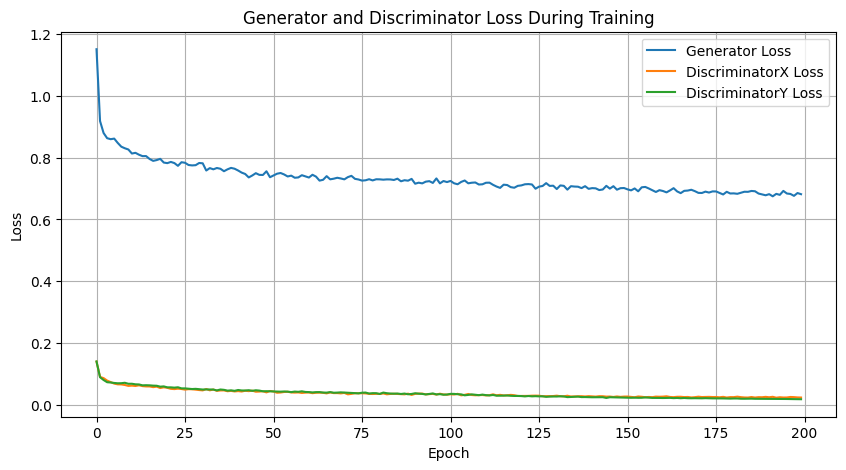

In [59]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의
G = Generator(nch_in=3, nch_out=3).to(device)  # A → B
F = Generator(nch_in=3, nch_out=3).to(device)  # B → A
D_X = Discriminator(nch_in=3).to(device)
D_Y = Discriminator(nch_in=3).to(device)

#가중치 초기화
G.apply(weights_init_normal)
F.apply(weights_init_normal)
D_X.apply(weights_init_normal)
D_Y.apply(weights_init_normal)


lambda_cyc = 10
decay_epoch = 100
num_epochs = 200

# 손실 함수
criterion_GAN = nn.MSELoss()
consistency = nn.L1Loss()

# 옵티마이저
optimizer_G = optim.Adam(list(G.parameters()) + list(F.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=LambdaLR(num_epochs, decay_epoch).step)

G_losses = []  
D_X_losses = []
D_Y_losses = []

for epoch in range(num_epochs):
    loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    G_epoch_loss = 0.0
    D_X_epoch_loss = 0.0
    D_Y_epoch_loss = 0.0
    num_batches = 0

    for batch in loop:
        image_A = batch["A"].to(device)
        image_B = batch["B"].to(device)

        # ------------------------------
        # 1. Train Generator G, F
        # ------------------------------
        optimizer_G.zero_grad()

        fake_B = G(image_A)
        fake_A = F(image_B)

        pred_fake_B = D_X(fake_B)
        pred_fake_A = D_Y(fake_A)

        loss_GAN_AB = criterion_GAN(pred_fake_B,  torch.ones_like(pred_fake_B))
        loss_GAN_BA = criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A))
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        recov_A = F(fake_B)
        recov_B = G(fake_A)

        loss_cyc_A = consistency(recov_A, image_A)
        loss_cyc_B = consistency(recov_B, image_B)
        loss_cycle = (loss_cyc_A + loss_cyc_B) / 2

        loss_G = loss_GAN + lambda_cyc * loss_cycle

        G_epoch_loss += loss_G.item()
        num_batches += 1

        loss_G.backward()
        optimizer_G.step()
      


        # ------------------------------
        # 2. Train Discriminator D_Y
        # ------------------------------
        optimizer_D_Y.zero_grad()
        pred_real_A = D_Y(image_A)
        pred_fake_A = D_Y(fake_A.detach())
        loss_D_Y = (criterion_GAN(pred_real_A, torch.ones_like(pred_fake_A)) +
                    criterion_GAN(pred_fake_A, torch.zeros_like(pred_fake_A))) * 0.5

        D_Y_epoch_loss += loss_D_Y.item()
        num_batches += 1

        loss_D_Y.backward()
        optimizer_D_Y.step()
        

        # ------------------------------
        # 2. Train Discriminators D_X
        # ------------------------------

        optimizer_D_X.zero_grad()
        pred_real_B = D_X(image_B)
        pred_fake_B = D_X(fake_B.detach())
        loss_D_X = (criterion_GAN(pred_real_B, torch.ones_like(pred_fake_B)) +
                    criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B))) * 0.5

        D_X_epoch_loss += loss_D_X.item()
        num_batches += 1
        

        loss_D_X.backward()
        optimizer_D_X.step()
        

        loop.set_postfix({
            "D_X": loss_D_X.item(),
            "D_Y": loss_D_Y.item(),
            "G": loss_G.item(),
        })

    lr_scheduler_D_Y.step()
    lr_scheduler_D_X.step()
    lr_scheduler_G.step()
    
    G_losses.append(G_epoch_loss / num_batches)
    D_X_losses.append(D_X_epoch_loss / num_batches)
    D_Y_losses.append(D_Y_epoch_loss / num_batches)


    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"D_X: {loss_D_X.item():.4f} | D_Y: {loss_D_Y.item():.4f} | "
          f"Generator Loss: {loss_G.item():.4f} | "
          f"Cycle Loss A: {loss_cyc_A.item():.4f}, B: {loss_cyc_B.item():.4f}")#

    # ------------------------------
    # Save sample test results
    # ------------------------------
    with torch.no_grad():
        test_batch = next(iter(val_dataloader))
        test_A = test_batch["A"].to(device)
        test_B = test_batch["B"].to(device)

        # A → B and B → A
        fake_B = G(test_A)
        fake_A = F(test_B)

        # Save
        os.makedirs("results", exist_ok=True)
        if epoch % 20 == 0 :
            vutils.save_image(torch.cat([test_A, fake_B], dim=0), f"results/epoch{epoch+1:03d}_A2B.png", normalize=True)
            vutils.save_image(torch.cat([test_B, fake_A], dim=0), f"results/epoch{epoch+1:03d}_B2A.png", normalize=True)

            print(f"[Test] Saved test results for epoch {epoch+1}")

#Graph
plt.figure(figsize=(10, 5))  
plt.title("Generator and Discriminator Loss During Training")  
plt.plot(G_losses, label="Generator Loss")  
plt.plot(D_X_losses, label="DiscriminatorX Loss")  
plt.plot(D_Y_losses, label="DiscriminatorY Loss")  

plt.xlabel("Epoch")  
plt.ylabel("Loss")   
plt.legend()         
plt.grid(True)       
plt.savefig("results/loss_graph.png") 
plt.show()  

